# Titanic Predictions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import cross_val_score

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

import warnings
warnings.filterwarnings('ignore')

## Feature Exploration

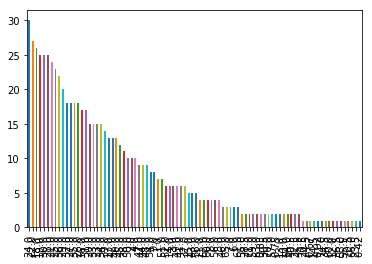

In [2]:
train['Age'].value_counts().plot(kind='bar')

In [3]:
#bins = [0,10,20,30,40,50,60,70]
#train['Age'] = pd.cut(train['Age'], bins)

In [4]:
#train['Age'].value_counts().sort_index().plot(kind = 'bar')

In [5]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [6]:
train['Sex'].value_counts() * 100 / len(train)

male      64.758698
female    35.241302
Name: Sex, dtype: float64

In [7]:
train.groupby('Survived')['Fare'].mean()

Survived
0    22.117887
1    48.395408
Name: Fare, dtype: float64

In [8]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [9]:
train.groupby('Survived')['SibSp'].value_counts()

Survived  SibSp
0         0        398
          1         97
          2         15
          4         15
          3         12
          8          7
          5          5
1         0        210
          1        112
          2         13
          3          4
          4          3
Name: SibSp, dtype: int64

In [10]:
train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [11]:
train.groupby('Survived')['Parch'].value_counts()

Survived  Parch
0         0        445
          1         53
          2         40
          4          4
          5          4
          3          2
          6          1
1         0        233
          1         65
          2         40
          3          3
          5          1
Name: Parch, dtype: int64

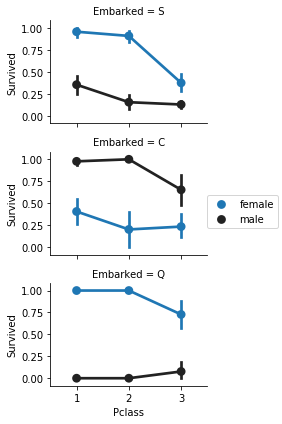

In [12]:
grid = sns.FacetGrid(train, row='Embarked', size=2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex')
grid.add_legend()

## Preprocessing

In [13]:
famsize = train['Parch'] + train['SibSp']
train['FamilySize'] = famsize

In [14]:
train.groupby('Survived')['FamilySize'].value_counts()

Survived  FamilySize
0         0             374
          1              72
          2              43
          5              19
          4              12
          3               8
          6               8
          10              7
          7               6
1         0             163
          1              89
          2              59
          3              21
          6               4
          4               3
          5               3
Name: FamilySize, dtype: int64

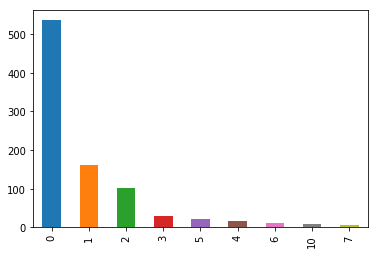

In [15]:
train['FamilySize'].value_counts().plot(kind='bar')

In [16]:
train['FamilySize'].head()

0    1
1    1
2    0
3    1
4    0
Name: FamilySize, dtype: int64

In [17]:
train['FamilySize'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: FamilySize, dtype: int64

In [18]:
train['Sex'][train['Sex'] == 'male'] = 0
train['Sex'][train['Sex'] == 'female'] = 1

In [19]:
test['Sex'][test['Sex'] == 'male'] = 0
test['Sex'][test['Sex'] == 'female'] = 1

In [21]:
train['Age_Categories'] = np.nan
train['Age_Categories'][train['Age'] <= 17] = 0
train['Age_Categories'][train['Age'] > 17] = 1
train['Age_Categories'][train.Age.isnull()] = 0.5

In [22]:
test['Age_Categories'] = np.nan
test['Age_Categories'][test['Age'] <= 17] = 0
test['Age_Categories'][test['Age'] > 17] = 1
test['Age_Categories'][test.Age.isnull()] = 0.5

In [23]:
train['Status'] = np.nan
train['Status'][train.Name.str.contains('Mr.')] = '0'
train['Status'][train.Name.str.contains('Mrs.')] = '1'
train['Status'][train.Name.str.contains('Master')] = '2'
train['Status'][train.Name.str.contains('Miss')] = '3'
train['Status'][train.Name.str.contains('Dr.')] = '4'
train['Status'][train.Status.isnull()] = '5'

In [24]:
test['Status'] = np.nan
test['Status'][test.Name.str.contains('Mr.')] = '0'
test['Status'][test.Name.str.contains('Mrs.')] = '1'
test['Status'][test.Name.str.contains('Master')] = '2'
test['Status'][test.Name.str.contains('Miss')] = '3'
test['Status'][test.Name.str.contains('Dr.')] = '4'
test['Status'][test.Status.isnull()] = '5'

In [25]:
train['Embarked'] = train['Embarked'].fillna('S')
test['Embarked'] = test['Embarked'].fillna('S')

In [26]:
train['Embarked'] = train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} )
train['Embarked'] = train['Embarked'].astype(int)

In [27]:
test['Embarked'] = test['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} )
test['Embarked'] = test['Embarked'].astype(int)

In [28]:
famsize = train['Parch'] + train['SibSp'] + 1
train['FamilySize'] = famsize
train['IsAlone'] = np.nan
train['IsAlone'][train['FamilySize'] == 1] = 0
train['IsAlone'][train['FamilySize'] > 1] = 1

In [29]:
famsize = test['Parch'] + test['SibSp'] + 1
test['FamilySize'] = famsize
test['IsAlone'] = np.nan
test['IsAlone'][test['FamilySize'] == 1] = 0
test['IsAlone'][test['FamilySize'] > 1] = 1

In [30]:
train['Embarked'] = train['Embarked'].fillna(0)
train['Fare'] = train['Fare'].astype(int)
#test['Fare'] = test['Fare'].astype(int)

## Descision Tree Classifier

In [32]:
y_train = train['Survived']
predictors = ['Pclass', 'Status', 'Embarked', 'Fare'] 
X_train = train[predictors]
X = X_train
y = y_train

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40)

TreeModel = DecisionTreeClassifier()

TreeModel.fit(X_train, y_train)

val_predictions = TreeModel.predict(X_test)

print(accuracy_score(y_test,val_predictions))

0.8305084745762712


In [35]:
scores = cross_val_score(TreeModel, X, y, cv=100,scoring='accuracy')

In [36]:
print(scores.mean())
TreeModel.feature_importances_

0.835861111111111


array([0.14757404, 0.4979538 , 0.07066111, 0.28381104])

In [37]:
print(predictors)

['Pclass', 'Status', 'Embarked', 'Fare']


In [38]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 15 columns):
PassengerId       418 non-null int64
Pclass            418 non-null int64
Name              418 non-null object
Sex               418 non-null object
Age               332 non-null float64
SibSp             418 non-null int64
Parch             418 non-null int64
Ticket            418 non-null object
Fare              417 non-null float64
Cabin             91 non-null object
Embarked          418 non-null int32
Age_Categories    418 non-null float64
Status            418 non-null object
FamilySize        418 non-null int64
IsAlone           418 non-null float64
dtypes: float64(4), int32(1), int64(5), object(5)
memory usage: 47.4+ KB


In [39]:
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())

In [40]:
Kaggle_predictions = TreeModel.predict(test[predictors])
Kaggle_predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [41]:
kaggle_ids = test["PassengerId"]
kaggle_df = {"PassengerId": kaggle_ids,
                 "Survived": Kaggle_predictions}
kaggle = pd.DataFrame(kaggle_df)

kaggle.to_csv('titanic_submission9.csv', index=False)

## Logistic Regreesion

In [51]:
from sklearn.linear_model import LogisticRegression

TrainReg = LogisticRegression()
TrainReg.fit(X_train, y_train)
Y_pred = TrainReg.predict(X_train)
train_accuracy = round(TrainReg.score(X_train, y_train) * 100, 2)

print(train_accuracy)

74.16


In [43]:
scores2 = cross_val_score(TrainReg, X, y, cv=100,scoring='accuracy')
print(scores2.mean())

0.7365833333333334


## Random Forest Classifier

In [44]:
from sklearn.ensemble import RandomForestClassifier

ForestModel = RandomForestClassifier(n_estimators= 14,max_features=len(predictors))

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=20)


ForestModel.fit(X_train, y_train)

val_predictions = ForestModel.predict(X_test)

print(accuracy_score(y_test,val_predictions))

0.7864406779661017


In [46]:
scores3 = cross_val_score(ForestModel, X, y, cv=100,scoring='accuracy')
print(scores3.mean())

0.8353888888888887


## K Nearest Neighbor Classifier

In [50]:
from sklearn.neighbors import KNeighborsClassifier

KnnModel = KNeighborsClassifier(n_neighbors = 4)
KnnModel.fit(X_train, y_train)
Y_pred = KnnModel.predict(X_test)
AccuracyKnn = round(KnnModel.score(X_train, y_train) * 100, 2)
print(AccuracyKnn)

81.88


In [48]:
scores3 = cross_val_score(KnnModel, X, y, cv=100,scoring='accuracy')
print(scores3.mean())

0.7503611111111111
